# **Apollon - B21-CAP0024**

In this project, we are going to build a recommendation system with TensorFlow Recurrent Neural Network as its core. The system will give recommendation to the users based on 10 recently followed artists' genres.


*   Dataset: [Music Artists Popularity](https://www.kaggle.com/pieca111/music-artists-popularity)
*   References: [Building a RNN Recommendation Engine with TensorFlow](https://medium.com/decathlondevelopers/building-a-rnn-recommendation-engine-with-tensorflow-505644aa9ff3)



---




## Exploratory Data Analysis & Data Cleaning



In [ ]:
! chmod 600 kaggle.json && (ls ~/.kaggle 2>/dev/null || mkdir ~/.kaggle) && mv kaggle.json ~/.kaggle/ && echo 'Done'

!kaggle datasets download pieca111/music-artists-popularity
!ls

Done
 79% 61.0M/76.7M [00:00<00:00, 81.3MB/s]
100% 76.7M/76.7M [00:00<00:00, 121MB/s] 
drive  music-artists-popularity.zip  sample_data


Describe method from Pandas only shows statistics for numeric columns, whilst the only numeric column is 'listeners_lastfm', thus it would not be so useful to describe the dataset we have. We decided to take 5 random samples from the dataset to know how it looks like.

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf

COLS = ['artist_lastfm', 'tags_lastfm', 'listeners_lastfm']

artists_df = pd.read_csv('music-artists-popularity.zip', usecols=COLS)

artists_df.sample(5)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (2,6) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,artist_lastfm,tags_lastfm,listeners_lastfm
939955,エナメル･ブラザース,NaN,1.0
607853,Suhapunta,NaN,38.0
1415678,NaN,NaN,NaN
480104,Cherry Mind,NaN,111.0
708030,Die Himmelberger,NaN,14.0


From the samples we got, we know that we need to perform data cleaning. Below are the filters that we use to clean the dataset.
</br >


*   Data with no artist name
*   No tags / genres
*   Less than 1000 listeners



In [ ]:
# Filter data with no artist name
artists_df = artists_df[artists_df['artist_lastfm'].notna()]

# Filter data with no tags / genres
artists_df = artists_df[artists_df['tags_lastfm'].notna()]

# Filter data with <= 1000 listeners
artists_df = artists_df[artists_df['listeners_lastfm'] > 1000]

artists_df

,artist_lastfm,tags_lastfm,listeners_lastfm
0,Coldplay,rock; alternative; britpop; alternative rock; ...,5381567.0
1,Radiohead,alternative; alternative rock; rock; indie; el...,4732528.0
2,Red Hot Chili Peppers,rock; alternative rock; alternative; Funk Rock...,4620835.0
3,Rihanna,pop; rnb; female vocalists; dance; Hip-Hop; Ri...,4558193.0
4,Eminem,rap; Hip-Hop; Eminem; hip hop; pop; american; ...,4517997.0
...,...,...,...
226653,Woody Simmons,folk; spotify; indie; banjo; feminist,1001.0
226654,Xome,noise; harsh noise; power electronics; Avant-G...,1001.0
226655,Γιάννης Πλούταρχος,Greek; Laika; pop; Greek Pop; male vocalists; ...,1001.0
226656,Рок-Ателье,russian rock; classic rock; Soviet Rock; rock;...,1001.0


It is shown that we only got 192,701 rows of data left. Next, we perform categorical encoding on genres so that we can feed the genres to the ML model. 

Since, artists might have multiple genres, we only use a genre with the minimum encoding code, because we had sorted the dictionary with the most popular genre.

In [ ]:
NUM_GENRES = 5

# Initialize a dictionary for the genres
genres_list = ['pop', 'rock', 'jazz', 'electronic', 'rnb', 'indie', 'alternative', 'dance', 'funk', 'hip hop', 'classic', 'reggae', 'folk', '90s', '80s', '70s', '60s', 'metal', 'acoustic', 'latin', 'synthpop', 'alternative rock', 'country', 'american', 'british', 'french', 'australian', 'japanese', 'korean', 'chinese']
genres_dict = {}

for idx, genre in enumerate(genres_list):
  genres_dict[genre] = idx + 1

genres_dict['others'] = len(genres_list) + 1

# Initialize a list for artists genres
tags = artists_df['tags_lastfm'].to_numpy()
genres = np.array([])

# Loop through each artist tag
for idx, tag in enumerate(tags):
  # Take first 5 tags
  temp = np.array(tag.split('; '))[:NUM_GENRES]
  encoded = np.array([])

  # Encode the genre with genre_dict
  for genre in temp:
    if genre in genres_dict:
      encoded = np.append(encoded, genres_dict[genre])
    else:
      encoded = np.append(encoded, genres_dict['others'])
  
  chosen_genre = encoded.min()

  # Append the tag list to the genres array
  genres = np.append(genres, chosen_genre)

# Append the genres array back to the dataframe
artists_df['genre'] = genres.astype(int).tolist()

artists_df.sample(5)

,artist_lastfm,tags_lastfm,listeners_lastfm,genre
48002,אביתר בנאי,israeli; hebrew; singer-songwriter; Israel; pi...,17163.0,31
135138,Geraldine Olivier,volksmusik; geraldine olivier; Schlager; Austr...,3015.0,31
104698,Cram,jazz; dutch; instrumental; groove; deep house;...,4884.0,3
208145,DJ 108,turntablism; Hip-Hop; electronic; russian; ins...,1217.0,4
175357,Mary Louise Knutson,jazz; All,1768.0,3


Finally, we rename some columns to make it sounds more logical and drop tags column which is not useful anymore.

In [ ]:
# Drop the tags column
artists_df = artists_df.drop(['tags_lastfm'], axis=1)

# Rename the columns
artists_df.rename(columns={'artist_lastfm': 'artist', 'listeners_lastfm': 'fans'}, inplace=True)

# Convert fans data type to integer
artists_df = artists_df.astype({'fans': 'int'})

artists_df.sample(5)

,artist,fans,genre
185506,Def Bond,1567,10
134469,Sarah Dougher,3046,6
151835,Waldschrat,2390,2
134467,Quick and the Dead,3046,2
154627,Thyrgrim,2301,31


## Dataset Loading and Preprocessing

We built a dataset, Followings, which has 500 records and comprised of seven genres of artists that the user recently followed and the next genre of artist that they would like to follow (target). Due to the RNN nature, it expects a sequence as the input. Hence, we transform the xs / input into a sequence manner.

In [ ]:
followings_df = pd.read_csv('/content/drive/MyDrive/Followings.csv')

followings_df.head(5)

,x1,x2,x3,x4,x5,x6,x7,target
0,1,2,1,16,1,8,1,1
1,25,4,6,4,25,4,4,4
2,1,4,1,2,4,5,4,4
3,2,4,4,1,2,4,30,4
4,15,15,1,14,14,15,1,15


In [ ]:
# Initialize sequences array to hold users' followings data
followings = np.empty((0,7))

# Transform the xs into a sequence
for i in range(len(followings_df)):
  user_followings = np.array([])
  
  # Loop through xs in a row and append it to an array
  for j in range(1, 8):
    user_followings = np.append(user_followings, followings_df.loc[i, 'x'+str(j)])

  # Add the user followings to the followings array
  followings = np.append(followings, np.expand_dims(user_followings, axis=0), axis=0)

# Add it to the dataframe
followings_df['followings'] = followings.astype(int).tolist()

# Drop the xs columns
for j in range(1, 8):
  followings_df = followings_df.drop(['x'+str(j)], axis=1)

followings_df.head(5)

,target,followings
0,1,"[1, 2, 1, 16, 1, 8, 1]"
1,4,"[25, 4, 6, 4, 25, 4, 4]"
2,4,"[1, 4, 1, 2, 4, 5, 4]"
3,4,"[2, 4, 4, 1, 2, 4, 30]"
4,15,"[15, 15, 1, 14, 14, 15, 1]"


## Dataset Splitting

For training purpose, we split the data into two parts, training data and test data. The split is 80:20, or more specifically, 400 for training and 100 for testing.

In [ ]:
from sklearn.model_selection import train_test_split

# Convert dataframe into lists
followings = followings_df['followings'].tolist()
target = followings_df['target'].tolist()

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(followings, target, test_size=0.2)

# Convert the splits to numpy arrays
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

tf.cast(X_train, dtype=tf.float32)
tf.cast(X_test, dtype=tf.float32)
tf.cast(y_train, dtype=tf.float32)
tf.cast(y_test, dtype=tf.float32)

print('Training: ' + str(X_train.shape), str(y_train.shape))
print('Testing: ' + str(X_test.shape), str(y_test.shape))

Training: (400, 7) (400,)
Testing: (100, 7) (100,)


## Model Definition

In [ ]:
model = tf.keras.Sequential([
      tf.keras.layers.InputLayer(input_shape=(7,)),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(32, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=250, validation_data=(X_test, y_test))

history

Epoch 1/250
13/13 [==============================] - 0s 15ms/step - loss: 7.3499 - accuracy: 0.0325 - val_loss: 6.5300 - val_accuracy: 0.0400
Epoch 2/250
13/13 [==============================] - 0s 3ms/step - loss: 4.8981 - accuracy: 0.0700 - val_loss: 5.0305 - val_accuracy: 0.0300
Epoch 3/250
13/13 [==============================] - 0s 5ms/step - loss: 3.9122 - accuracy: 0.0675 - val_loss: 4.3092 - val_accuracy: 0.0300
Epoch 4/250
13/13 [==============================] - 0s 5ms/step - loss: 3.5337 - accuracy: 0.0825 - val_loss: 4.0053 - val_accuracy: 0.0300
Epoch 5/250
13/13 [==============================] - 0s 3ms/step - loss: 3.3517 - accuracy: 0.1075 - val_loss: 3.8861 - val_accuracy: 0.0500
Epoch 6/250
13/13 [==============================] - 0s 3ms/step - loss: 3.2485 - accuracy: 0.1225 - val_loss: 3.8272 - val_accuracy: 0.0500
Epoch 7/250
13/13 [==============================] - 0s 3ms/step - loss: 3.1727 - accuracy: 0.1400 - val_loss: 3.8113 - val_accuracy: 0.0500
Epoch 8/250


## Model Evaluation Plot

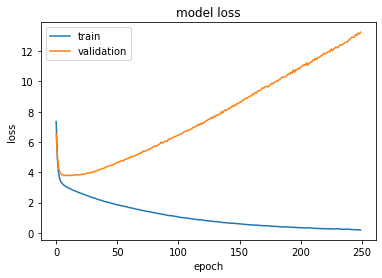

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
import pathlib

export_dir = 'saved_model/1'
tf.saved_model.save(model, export_dir=export_dir)

converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)

# Set the optimzations
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_LATENCY]

# Invoke the converter to finally generate the TFLite model
tflite_model = converter.convert()

tflite_model_file = pathlib.Path('./model.tflite')
tflite_model_file.write_bytes(tflite_model)


FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.
INFO:tensorflow:Assets written to: saved_model/1/assets


10688